## 목차
1. 데이터 준비  
    [1-1. 라이브러리 불러오기](#라이브러리-불러오기)  
    [1-2. 데이터 불러오기](#데이터-불러오기--전처리)  
2. 가설 검증
    [2-1. 노쇼 수 가설 검증](#가설--특정-시간대요일에-노쇼-물품이-많을-것이다)

# 라이브러리 불러오기

In [5]:
import pickle
import pandas as pd
import os
import openai
import json
import matplotlib.pyplot as plt
import seaborn as sns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   platform           555 non-null    object        
 1   original_link      555 non-null    object        
 2   post_time          555 non-null    datetime64[ns]
 3   title              555 non-null    object        
 4   view_count         555 non-null    int32         
 5   like_count         555 non-null    int32         
 6   price              555 non-null    int32         
 7   images             551 non-null    object        
 8   description        555 non-null    object        
 9   category           284 non-null    object        
 10  status             284 non-null    object        
 11  seller_location    183 non-null    object        
 12  title_nouns        555 non-null    object        
 13  seller_location_1  183 non-null    object        
dtypes: datetim

# 데이터 불러오기 & 전처리

In [12]:
# 피클 파일 경로
file_path = 'data/filter_df.pickle'

# 피클 파일 불러오기
with open(file_path, 'rb') as file:
    df = pickle.load(file)

# 데이터 프레임으로 변환
df = pd.DataFrame(df)
# 광고글 제거
df=df[~df['title'].str.contains('임대|야놀자|입장권|상품권|포인트|야놀|주차권|쿠폰|구매|비행기|종일권|자유이용권', na=False)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491 entries, 0 to 554
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   platform           491 non-null    object        
 1   original_link      491 non-null    object        
 2   post_time          491 non-null    datetime64[ns]
 3   title              491 non-null    object        
 4   view_count         491 non-null    int32         
 5   like_count         491 non-null    int32         
 6   price              491 non-null    int32         
 7   images             487 non-null    object        
 8   description        491 non-null    object        
 9   category           268 non-null    object        
 10  status             268 non-null    object        
 11  seller_location    174 non-null    object        
 12  title_nouns        491 non-null    object        
 13  seller_location_1  174 non-null    object        
dtypes: datetim

# 가설 : 특정 시간대/요일에 노쇼 물품이 많을 것이다.

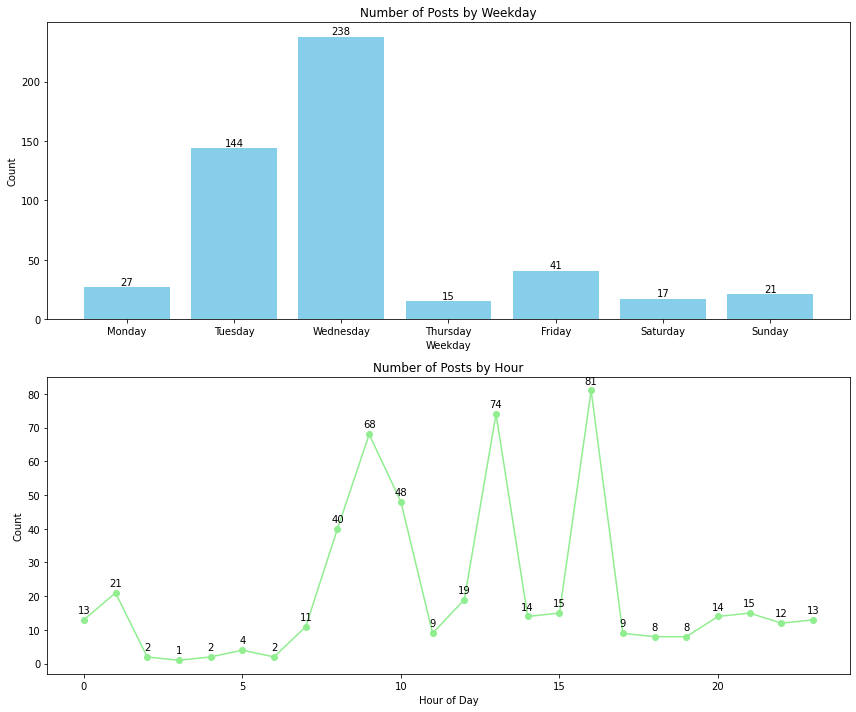

In [10]:
# 'post_time'에서 요일과 시간 추출
df['weekday'] = df['post_time'].dt.day_name()  # 요일 이름
df['hour'] = df['post_time'].dt.hour  # 시간 (0-23)

# 요일 순서 설정
ordered_weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = pd.Categorical(df['weekday'], categories=ordered_weekdays, ordered=True)

# 요일별 갯수 집계
weekday_counts = df['weekday'].value_counts().sort_index()

# 시간대별 갯수 집계
hour_counts = df['hour'].value_counts().sort_index()

# 그래프 설정
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# 요일별 갯수 시각화 (막대 그래프)
axs[0].bar(weekday_counts.index, weekday_counts.values, color='skyblue')
axs[0].set_title('Number of Posts by Weekday')
axs[0].set_xlabel('Weekday')
axs[0].set_ylabel('Count')

# 개수 표시
for i, count in enumerate(weekday_counts):
    axs[0].text(i, count + 2, str(count), ha='center', fontsize=10)

# 시간대별 갯수 시각화 (선 그래프)
axs[1].plot(hour_counts.index, hour_counts.values, marker='o', color='lightgreen')
axs[1].set_title('Number of Posts by Hour')
axs[1].set_xlabel('Hour of Day')
axs[1].set_ylabel('Count')

# 개수 표시
for i, count in enumerate(hour_counts):
    axs[1].text(i, count + 2, str(count), ha='center', fontsize=10)

# 레이아웃 조정 및 그래프 출력
plt.tight_layout()
plt.show()